<Body>   
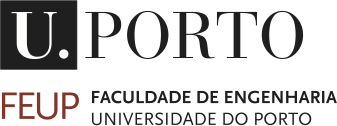   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p><b>Anibal C. Matos </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# **Complete:**

 <font color='red'> Christian Geyer </font>

# Underwater inspection of 3D objects using stereo vision

In this assignment, you will explore multiview geometry and 3D reconstruction using data acquired from a calibrated stereo camera rig operating underwater. The stereo rig captures synchronized left and right images of a horizontally placed anode as the sensor moves from left to right along the object.

The underwater environment adds challenges such as light scattering, refraction and contrast loss, which make stereo correspondence and 3D reconstruction more difficult than in air. Your goal is to process this dataset to generate a textured 3D model of the anode, analyze its geometric and physical properties, and evaluate reconstruction quality under different strategies.

The goal is to automatize an inspection pipeline completely. You will build a pipeline that includes:

1) Extracting 3D point clouds from stereo pairs. Texturing the point cloud for visual realism.

2) Applying feature-based or dense stereo matching to estimate disparities.

3) Preprocessing and filtering noisy or spurious 3D points.

4) Registering multiple point clouds into a single coherent 3D model.

5) Performing physical measurements (width, height, volume and bracket dimensions).




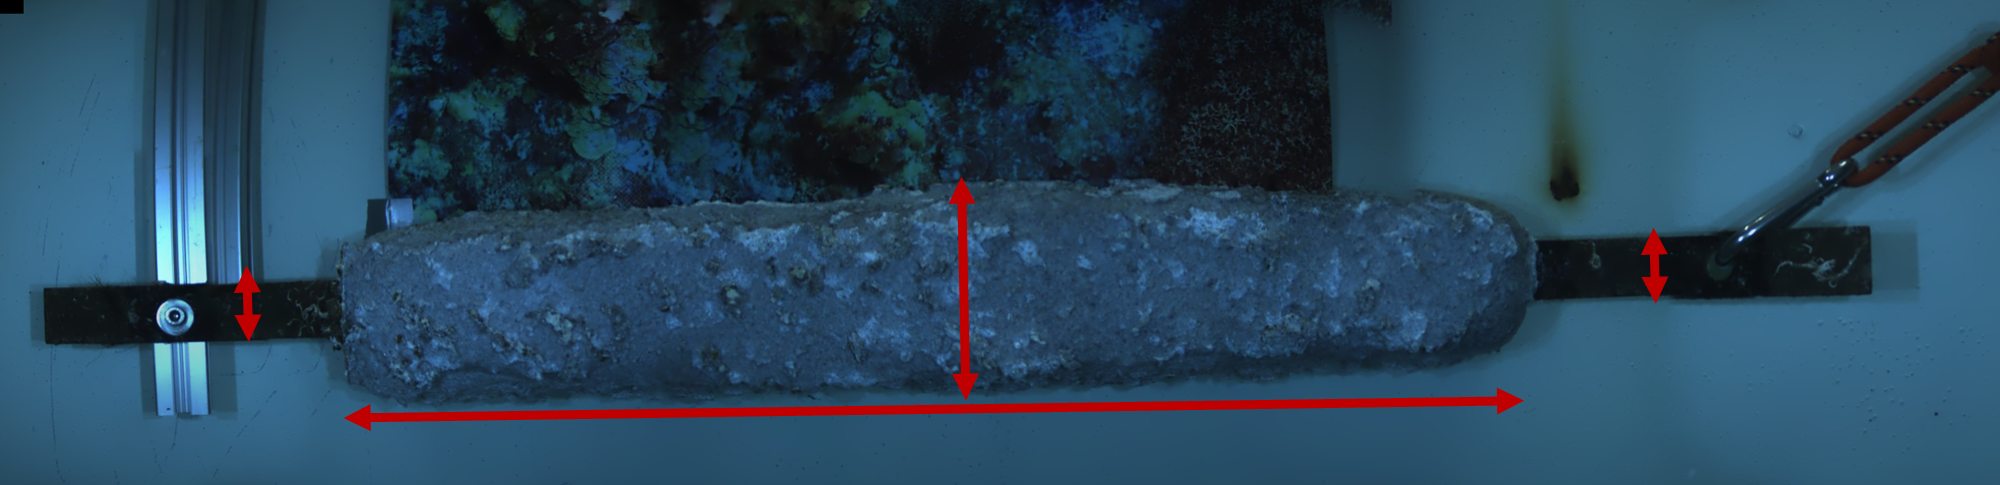

## Prepare Libraries

In [53]:
# Install Open3D library
!pip install open3d

In [54]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import pickle
import os
from typing import Any, List, Tuple, Dict, Optional


In [55]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [56]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

## Prepare Dataset


This dataset will be available in the following directory `./PM_Dataset/PM_Anode_Data/`. Inside this folder, you will find:

1) A sequence of stereo image pairs (see folders `Left_Image` and `Right_Image`). Each stereo image pair follows a timestamp-based naming convention, for example:

> `left1703089978884525728.png` and `right1703089978884525728.png`

>`left1703089979137789888.png` and `right1703089979137789888.png`

The numeric component in each filename represents a precise capture timestamp, typically derived from the system clock or camera hardware trigger. These timestamps indicate the exact moment of acquisition and are crucial for ensuring temporal synchronization between the left and right cameras.

When constructing 3D point clouds, it is essential to match left and right images captured at the same or nearest timestamps. Even small temporal mismatches-on the order of milliseconds-can lead to inconsistent geometry, disparity errors and blurring of reconstructed features, especially in dynamic or refractive underwater environments. Therefore, synchronization between stereo pairs should be performed as tightly as possible, ideally by matching image files whose timestamps are identical or differ by less than the acquisition precision of the system.


2) The stereo calibration parameters in file `StereoCalib.xml` like Intrinsic matrices ($K_1, K_2$), Lens distortion coefficients  ($D_1, D_2$) and Extrinsic parameters (rotation and translation between cameras).



### Download Dataset

In [57]:
# Download Dataset for training
!wget 'https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EYGpPCgkmrJCqVeHdDlozDYB6P5-ZQzOr-ByaAhYidJnMg?download=1' -O PM_Dataset.zip

--2025-11-15 17:38:03--  https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EYGpPCgkmrJCqVeHdDlozDYB6P5-ZQzOr-ByaAhYidJnMg?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.10, 13.107.138.10
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/Reconstruction_Underwater/PM_Anode_Data_2025.zip?ga=1 [following]
--2025-11-15 17:38:04--  https://uporto-my.sharepoint.com/personal/up488707_up_pt/Documents/AULAS/UC_Perception/DataSets/Reconstruction_Underwater/PM_Anode_Data_2025.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 405245962 (386M) [application/x-zip-compressed]
Saving to: 'PM_Dataset.zip'

PM_Dataset.zip      100%[===================>] 386.47M  55.4MB/s    in 7.9s    

2025-11-15 17:38:12 (4

In [58]:
# Extract point clouds from ZIP file.
import zipfile
import os

with zipfile.ZipFile("PM_Dataset.zip", mode="r") as archive:
  for file in archive.namelist():
    archive.extract(file, "PM_Dataset/")

# Exercise 1 — Load the stereo calibration parameters and visualize a few undistorted left/right image pairs.

The first step in your 3D reconstruction pipeline is to load the stereo calibration parameters and inspect how well the cameras are geometrically aligned. Each camera in the stereo rig has its own set of internal characteristics - its intrinsic parameters, which include the focal length and optical center - as well as distortion coefficients that describe how the lens bends light. The calibration file also contains the extrinsic parameters, defining how the right camera is positioned and oriented relative to the left one.

Once these parameters are loaded, the next task is to undistort the raw underwater images. This process corrects for lens distortion and refraction effects that are especially noticeable when imaging through water and a camera housing. Undistortion ensures that straight edges in the real world appear straight in the image, which is fundamental for accurate depth estimation later on. After undistorting a few stereo pairs, take a moment to visualize the left and right images side by side. Observe how the features line up horizontally - well-aligned, distortion-free image pairs will produce more reliable correspondences when you compute disparities and reconstruct depth.

## Results of Exercise 1

* load_stereo_calibration_parameters() loads the contents of the .xml file into a python dict
* match_lists(): From two unordered lists, find a match for each element of the first list in the second list. If there is no match within a specified interval, don't include the element in the final list.
* convert_name2timestamp(): helper function to convert a file name "left<timestamp>.png" into the int timestamp
* convert_timestamp2path(): helper function to convert the int timestamp into the correct path to load the corresponding image from the dataset (left or right).
* undistort_images(): Function to (undistort) or (undistort + rectify) all left and right images
* plot_image_pair(): helper function to plot left and right images side by side, with some horizontal guide lines to compare images.
* exercise1(): get the stereo_calibration_dict, the left and right timestamps (matched), and the undistorted left and right images of the stereo pairs found

Undistortion does not suffice to correctly align left and right stereo image pairs. Rectification is needed.


In [59]:
# do implementation here

import xml.etree.ElementTree as ET
import cv2
import re

def load_stereo_calibration_parameters(filepath: str) -> Dict[str, Any]:
  # initialize a dictionary to save the .xml file data
  xml_dict = {}

  # extract names of .xml file Elements using ElementTree
  tree = ET.parse(filepath) # ElementTree
  root = tree.getroot() # root Element
  names = []
  for i in range(len(root)):
    child = root[i]
    names.append(child.tag)

  # create FileStorage to read sequences and mappings saved in .xml file
  fs = cv2.FileStorage(filepath, cv2.FILE_STORAGE_READ)
  for name in names:
    node = fs.getNode(name)
    if node.isMap():
      xml_dict[name] = node.mat()
    elif node.isSeq():
      data = []
      for i in range(node.size()):
        data.append(node.at(i).real())
      xml_dict[name] = np.array(data)

  # release file structure always
  fs.release()

  # return dictionary
  return xml_dict  

def match_lists(list1: List[int], list2: List[int], max_diff: int) -> Tuple[List[int], List[int]]:
  # max_diff
  if max_diff is None:
    max_diff = np.inf

  # remove duplicates
  list1 = list(set(list1))
  list2 = list(set(list2))

  # append +inf and -inf to list2 (for the main algorithm to be elegantly implemented)
  list2.append(np.inf)
  list2.append(-np.inf)

  # sort - O(NlogN + MlogM)
  list1.sort()
  list2.sort()

  # initialize indices and final lists
  idx1 = 0
  idx2 = 1 # start after the -inf element
  matched_list1 = []
  matched_list2 = []
  while idx1 < len(list1): # search a match for each left element - O(N + M)
    while list1[idx1] > list2[idx2]:
      idx2 += 1 # go to first right element that exceeds current left element
    best_list2 = list2[idx2-1]
    if abs(list1[idx1]-list2[idx2]) < abs(list1[idx1]-best_list2): # find closest right element
      best_list2 = list2[idx2]
    if abs(list1[idx1]-best_list2) <= max_diff: # check if difference is within the tolerance
      # append to final lists
      matched_list1.append(list1[idx1])
      matched_list2.append(best_list2)
    idx1 += 1 # search match for the next left element

  # return final matched lists
  return matched_list1, matched_list2

def convert_name2timestamp(name: str) -> int:
  delimiters = ["left", "right", ".png"]
  delimiters = list(map(re.escape, delimiters)) # escape special meaning of certain characters like '.' in '.png'
  delimiters = "|".join(delimiters) # create delimiters expression for re.split function, simply separating them by "|"
  s_list = re.split(delimiters, name) # split the filename
  timestamp = s_list[1] # timestamp will always be the second element of the list
  return int(timestamp)

def convert_timestamp2path(path: str, timestamp: int, camera: str):
  return path + camera + str(timestamp) + ".png"

def undistort_images(pathL, pathR, tL_list, tR_list, calib_dict, mode):
  if mode is None:
    mode = "rectify"

  # read relevant calibration matrices
  KL = calib_dict["K1"]
  DL = calib_dict["D1"]
  PL = calib_dict["P1"]
  RL = calib_dict["R1"]
  KR = calib_dict["K2"]
  DR = calib_dict["D2"]
  PR = calib_dict["P2"]
  RR = calib_dict["R2"]

  # read left and right images
  left_images = []
  right_images = []
  for tl, tr in zip(tL_list, tR_list):
    # get file paths
    pL = convert_timestamp2path(pathL, tl, "left")
    pR = convert_timestamp2path(pathR, tr, "right")
    # read images
    imgL = cv2.imread(pL)
    imgR = cv2.imread(pR)
    # append to image list
    left_images.append(imgL)
    right_images.append(imgR)

  # undistort left and right camera images
  left_undistorted = []
  right_undistorted = []
  # compute the mapping only once (costly method)
  hL, wL = left_images[0].shape[:2]
  hR, wR = right_images[0].shape[:2]
  if mode == "undistort":
    newKL, roiL = cv2.getOptimalNewCameraMatrix(KL, DL, (wL, hL), 1)
    newKR, roiR = cv2.getOptimalNewCameraMatrix(KR, DR, (wR, hR), 1)
    map1L, map2L = cv2.initUndistortRectifyMap(KL, DL, None, newKL, (wL, hL), cv2.CV_32FC1)
    map1R, map2R = cv2.initUndistortRectifyMap(KR, DR, None, newKR, (wR, hR), cv2.CV_32FC1)
  elif mode == "rectify":
    map1L, map2L = cv2.initUndistortRectifyMap(KL, DL, RL, PL, (wL,hL), cv2.CV_32FC1)
    map1R, map2R = cv2.initUndistortRectifyMap(KR, DR, RR, PR, (wL,hL), cv2.CV_32FC1) # use same size as left image

  for imgL, imgR in zip(left_images, right_images):
    # remap for undistortion (fast method)
    undistortedL = cv2.remap(imgL, map1L, map2L, cv2.INTER_LINEAR)
    undistortedR = cv2.remap(imgR, map1R, map2R, cv2.INTER_LINEAR)

    if mode == "undistort":
      # crop with the same roi -> the intersection of left and right ROIs
      xL, yL, w_roiL, h_roiL = roiL
      xR, yR, w_roiR, h_roiR = roiR
      x = max(xL, xR)
      y = max(yL, yR)
      w = min(xL+w_roiL, xR+w_roiR) - x
      h = min(yL+h_roiL, yR+h_roiR) - y
      undistorted_croppedL = undistortedL[y:y+h, x:x+w]
      undistorted_croppedR = undistortedR[y:y+h, x:x+w]

      # append to lists of undistorted images
      left_undistorted.append(undistorted_croppedL)
      right_undistorted.append(undistorted_croppedR)

    elif mode == "rectify":
      # append to lists of undistorted images
      left_undistorted.append(undistortedL)
      right_undistorted.append(undistortedR)

  # return undistorted images
  return left_undistorted, right_undistorted

def plot_image_pair(left_image, left_title, right_image, right_title, lines):
  left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
  right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
  fig, axs = plt.subplots(1, 2, figsize=(8, 20))
  axs[0].imshow(left_image)
  axs[1].imshow(right_image)
  if lines is True:
    for y in range(100, 1000, 200):
      for i in range(2):
        # draw horizontal red lines
        axs[i].axhline(y, color='r', linestyle='--')
  if left_title is not None:
    axs[0].set_title(left_title)
  if right_title is not None:
    axs[1].set_title(right_title)

def exercise1(verbose: bool = True) -> Dict[str, Any]:
  
  # 1) extract stereo calibration parameters
  xml_path = "PM_Dataset/PM_Anode_Data/StereoCalib.xml"
  stereo_calib_dict = load_stereo_calibration_parameters(xml_path)
  if verbose:
    for key, value in stereo_calib_dict.items():
      print(f"{key}: \n{value}\n")

  # 2) match timestamps
  pathL = "./PM_Dataset/PM_Anode_Data/Left_Image/"
  pathR = "./PM_Dataset/PM_Anode_Data/Right_Image/"
  timestampsL = [convert_name2timestamp(name) for name in os.listdir(pathL)]
  timestampsR = [convert_name2timestamp(name) for name in os.listdir(pathR)]
  max_diff = None # milliseconds

  timestampsL_matched, timestampsR_matched = match_lists(timestampsL, timestampsR, max_diff)

  if verbose:
    print(f"{len(timestampsL)} left images and {len(timestampsR)} right images found.")
    print(f"{len(timestampsL_matched)} stereo pairs found.")
    for i in range(len(timestampsL_matched)):
      print(f"  Pair {i+1}: {timestampsL_matched[i]} <-> {timestampsR_matched[i]}")

  # 3) undistort images
  mode = "undistort"
  left_undistorted, right_undistorted = undistort_images(pathL, pathR, timestampsL_matched, timestampsR_matched, stereo_calib_dict, mode=mode)

  if verbose:
    if mode == "undistort":
      print(f"Undistorted {len(left_undistorted)} left and {len(right_undistorted)} right images.")
    elif mode == "rectify":
      print(f"Undistorted and Rectified {len(left_undistorted)} left and {len(right_undistorted)} right images.")
  # plot two images side by side with horizontal lines to compare left to right
  titleL = "Left " + mode
  titleR = "Right " + mode
  index = 0 # first image pair
  plot_image_pair(left_undistorted[index], titleL, right_undistorted[index], titleR, lines=True)
  plt.show()

  return stereo_calib_dict, timestampsL_matched, timestampsR_matched, left_undistorted, right_undistorted

**Deliverable**:


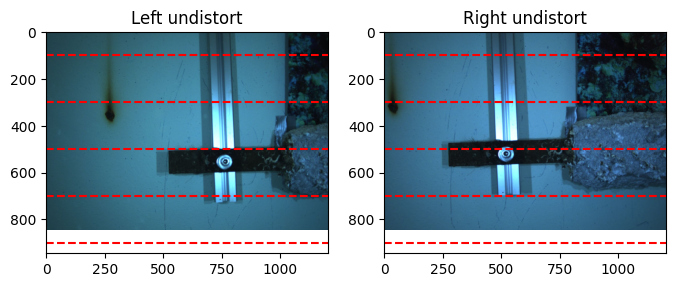

In [60]:
# (Code) Show one undistorted pair of images (Left and Right)
stereo_calib_dict, timestampsL, timestampsR, left_undistorted, right_undistorted = exercise1(verbose=False)

# Exercise 2 - Stereo Matching and Depth Map Estimation

In this stage, you will **explore one of two** different strategies for computing disparity between the left and right images - each offering distinct advantages in terms of accuracy, density and computational cost.

- Option A (Feature-Based Matching). It begin by detecting distinctive image features using algorithms such as SIFT or ORB. These keypoints capture visually stable patterns that can be reliably identified in both the left and right views. Once detected, match the corresponding features across the image pair to establish pixel correspondences.
With these matches, estimate the fundamental or essential matrix to describe the geometric relationship between the two cameras. Using this relationship, you can then triangulate the matched points to obtain their 3D coordinates in space.

- Option B (Dense Stereo Matching).
Alternatively, you can adopt a dense correspondence approach to compute a disparity value for every pixel in the image. This can be achieved using algorithms like SSD, SAD or OpenCV StereoBM or StereoSGBM, which leverage block matching and semi-global optimization to estimate disparities across the entire image.
Once the disparity map is computed, convert it into a depth map using the known camera baseline (distance between the two cameras) and focal length.

## Results of Exercise 2

* extract_keypoints_and_descriptors_SIFT() (self explanatory)
* match_descriptors(): find good matches between 2 lists of descriptors
* matches2disparity(): compute the disparity map given 2 keypoint lists and a matches list
* plot_feature_based_disparity(): helper function to display sparse disparity map given the keypoints and matches lists.

We use SIFT in the feature based approach to compute disparities and depth maps.

In [220]:
# do implementation here

from matplotlib.colors import Normalize

def extract_keypoints_and_descriptors_SIFT(img: np.ndarray, sift_params: dict[str, Any]) -> Tuple[Any, Any]:
    
    sift = cv2.SIFT_create(**sift_params)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def match_descriptors(desL: np.ndarray, desR: np.ndarray, ratio: float) -> Tuple[Any, Any]:
    # brute force matcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desL, desR, k=2)
    good = []
    # filter using Lowe's ratio test for unique features
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    return good

def matches2disparity(kptsL: Any, kptsR: Any, matches: Any) -> Tuple[List[int], List[Any]]:
    disparities = []
    matches_filt = []
    for i in range(len(matches)):
        match = matches[i][0]
        idxL = match.queryIdx
        idxR = match.trainIdx
        uL, vL = kptsL[idxL].pt
        uR, vR = kptsR[idxR].pt
        disparity = uL - uR
        dv = abs(vL - vR)
        if disparity > 0 and dv <= 2:
            disparities.append(disparity)
            matches_filt.append([match])

    return disparities, matches_filt

def disparity2depth(disparities: List[int], calib_dict: Dict[str, Any]) -> List[float]:
    P2 = calib_dict["P2"]
    fx = P2[0,0]
    B = -P2[0, 3] / fx

    depths = []
    for d in disparities:
        Z = (fx * B) / float(d)
        depths.append(Z)

    return depths


def plot_feature_based_disparity(img, kpts, matches, disp, radius, title, side):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if side == 'left':
        kpts = np.asarray([kpts[m[0].queryIdx].pt for m in matches])
    else:
        kpts = np.asarray([kpts[m[0].trainIdx].pt for m in matches])

    disp = np.asarray(disp)

    vmin = np.min(disp)
    vmax = np.max(disp)

    print(f"vmin = {vmin}, vmax = {vmax}")

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.imshow(img)
    sc = ax.scatter(kpts[:, 0], kpts[:, 1], s=radius**2, c=disp, cmap = "inferno",
                    norm = Normalize(vmin=vmin, vmax=vmax), alpha = 0.9)
    ax.set_xticks([]); ax.set_yticks([])
    ax.invert_yaxis()
    ax.set_title(title)
    cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.02)


def find_optimal_threshold(depths: list[float]) -> float:
    depths = np.array(depths)
    hist, bin_edges = np.histogram(depths, bins = 100)
    d = 0.5*(bin_edges[0:-1] + bin_edges[1:]) # distance values at histogram bin centers
    p = hist / np.sum(hist) # probabilities
    w0 = np.zeros_like(d)
    w1 = np.zeros_like(d)
    mu0 = np.zeros_like(d)
    mu1 = np.zeros_like(d)
    muT = np.sum(d*p)
    sigma_b_2 = np.zeros_like(d) # use formula w0*w1*(mu0-mu1)^2
    for i in range(len(d)-1):

        if i == 0:
            w0[i] = p[i] 
            w1[i] = 1-w0[i]
            mu0[i] = d[i]
            mu1[i] = (muT - w0[i]*mu0[i]) / w1[i]
        else:
            w0[i] = w0[i-1] + p[i]
            w1[i] = 1 - w0[i]
            mu0[i] = (w0[i-1]*mu0[i-1] + p[i]*d[i]) / w0[i]
            mu1[i] = (muT - w0[i]*mu0[i]) / w1[i]
        if w0[i] == 0 or w1[i] == 0:
            continue
        sigma_b_2[i] = w0[i]*w1[i]*(mu0[i]-mu1[i])**2
    # extract best threshold
    i_list = np.where(sigma_b_2 == np.max(sigma_b_2))[0]
    if len(i_list) > 1:
        i_best = int((i_list[0] + i_list[-1]) / 2)
    else:
        i_best = i_list[0]
    threshold_best = d[i_best]

    return threshold_best



# rectify all images
def exercise2_1(verbose: bool) -> Tuple[list[np.ndarray], list[np.ndarray]]:
    # 1) rectify images
    pathL = "./PM_Dataset/PM_Anode_Data/Left_Image/"
    pathR = "./PM_Dataset/PM_Anode_Data/Right_Image/"
    mode = "rectify"
    
    if verbose:
        print("Rectifying images...")
    
    left_rectified, right_rectified = undistort_images(pathL, pathR, timestampsL, timestampsR, stereo_calib_dict, mode=mode)

    if verbose:
        print(f"Undistorted and Rectified {len(left_rectified)} left and {len(right_rectified)} right images.")

    return left_rectified, right_rectified

# compute disparity and depth maps for some images
def exercise2_2(imgL_list: list[np.ndarray], imgR_list: list[np.ndarray], indices: list[int], calib_dict: Dict[str, Any], verbose: bool) -> Tuple[list[Any], list[Any], list[Any], list[Any], list[Any]]:

    # 1) extract keypoints and descriptors using SIFT
    kptsL_list, dscL_list, kptsR_list, dscR_list = [], [], [], []
    sift_params = {"nfeatures": 10000,
                   "contrastThreshold": 0.01,
                   "edgeThreshold": 20}
    
    for ii in range(len(indices)):
        i = indices[ii]

        if verbose:
            print(f"Extracting keypoints and descriptors for image pair: {i} ({ii+1}/{len(indices)})")
        kptsL, dscL = extract_keypoints_and_descriptors_SIFT(imgL_list[i], sift_params)
        kptsR, dscR = extract_keypoints_and_descriptors_SIFT(imgR_list[i], sift_params)
        if verbose:    
            print(f"  keypoints: {len(kptsL)} <-> {len(kptsR)}")
        kptsL_list.append(kptsL)
        dscL_list.append(dscL)
        kptsR_list.append(kptsR)
        dscR_list.append(dscR)

    # 3) match keypoints
    ratio = 0.75
    matches_list = []
    for ii in range(len(indices)):
        i = indices[ii]
        if verbose:
            print(f"Matching keypoints for image pair: {i} ({ii+1}/{len(indices)})")
        matches = match_descriptors(dscL_list[ii], dscR_list[ii], ratio)
        if verbose:
            print(f"  matches: {len(matches)}/{len(dscL_list[ii])}")
        matches_list.append(matches)

    # 4) compute disparities, filter out non aligned matches
    disparities_list = []
    for ii in range(len(indices)):
        i = indices[ii]
        if verbose:
            print(f"Computing disparities for image pair: {i} ({ii+1}/{len(indices)})")
        disparities, matches_filt = matches2disparity(kptsL_list[ii], kptsR_list[ii], matches_list[ii])
        if verbose:
            print(f"  valid matches: {len(matches_filt)}/{len(matches_list[ii])}")
        disparities_list.append(disparities)
        # update matches list with filtered values only
        matches_list[ii] = matches_filt
    
    # 5) compute depths from disparities
    depth_list = []
    for ii in range(len(indices)):
        if verbose:
            print(f"Computing depths for image pair: {i} ({ii+1}/{len(indices)})")
        disparities = disparities_list[ii]
        depths = disparity2depth(disparities, calib_dict)
        depth_list.append(depths)

    return disparities_list, depth_list, kptsL_list, kptsR_list, matches_list

In [132]:
left_rectified, right_rectified = exercise2_1(verbose=True)

Rectifying images...
Undistorted and Rectified 138 left and 138 right images.


In [162]:
# select some image indices to compute disparities
indices = [0, 2, 40, 42, 80, 82, 120, 122, 137]
disparities_list, depth_list, kptsL_list, kptsR_list, matches_list = exercise2_2(left_rectified, right_rectified, indices, stereo_calib_dict, verbose=True)

Extracting keypoints and descriptors for image pair: 0 (1/9)
  keypoints: 4103 <-> 9065
Extracting keypoints and descriptors for image pair: 2 (2/9)
  keypoints: 4231 <-> 9343
Extracting keypoints and descriptors for image pair: 40 (3/9)
  keypoints: 10000 <-> 10000
Extracting keypoints and descriptors for image pair: 42 (4/9)
  keypoints: 10000 <-> 10000
Extracting keypoints and descriptors for image pair: 80 (5/9)
  keypoints: 10000 <-> 10000
Extracting keypoints and descriptors for image pair: 82 (6/9)
  keypoints: 10001 <-> 10000
Extracting keypoints and descriptors for image pair: 120 (7/9)
  keypoints: 7211 <-> 5290
Extracting keypoints and descriptors for image pair: 122 (8/9)
  keypoints: 6621 <-> 4863
Extracting keypoints and descriptors for image pair: 137 (9/9)
  keypoints: 4149 <-> 2799
Matching keypoints for image pair: 0 (1/9)
  matches: 816/4103
Matching keypoints for image pair: 2 (2/9)
  matches: 901/4231
Matching keypoints for image pair: 40 (3/9)
  matches: 3349/1000

**Deliverable**:


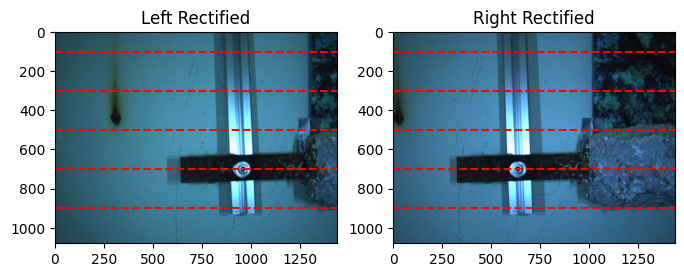

In [222]:
# (Code) Show corresponding epipolar lines to verify rectification.
index = 0 # first image pair
titleL = "Left Rectified"
titleR = "Right Rectified"
plot_image_pair(left_rectified[index], titleL, right_rectified[index], titleR, lines=True)
plt.show()

vmin = 276.4420166015625, vmax = 344.5391845703125
vmin = 272.2906494140625, vmax = 343.400390625
vmin = 244.3818359375, vmax = 326.6942138671875
vmin = 240.22991943359375, vmax = 310.2545471191406
vmin = 210.3621826171875, vmax = 282.2079849243164
vmin = 229.05731201171875, vmax = 298.3021755218506
vmin = 239.14599609375, vmax = 301.44266510009766
vmin = 236.38726806640625, vmax = 340.95556640625
vmin = 231.79104614257812, vmax = 352.21783447265625


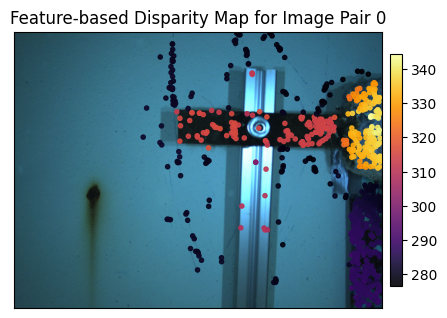

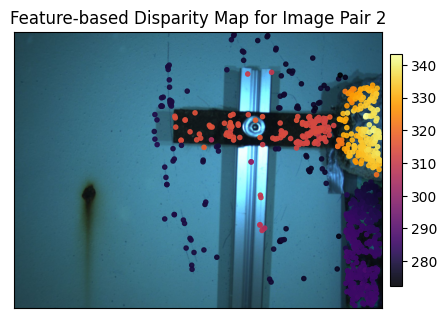

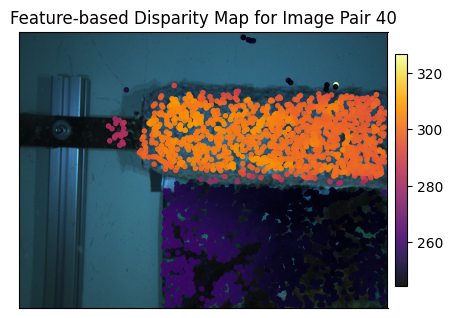

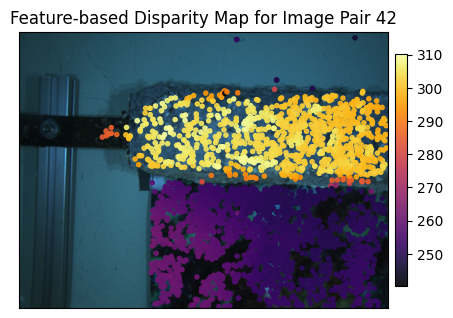

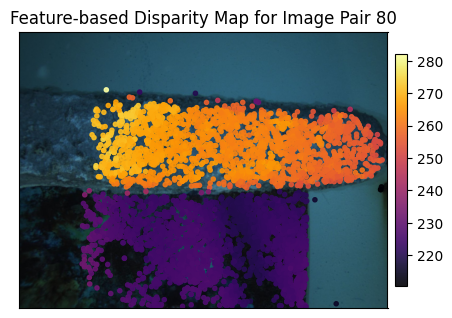

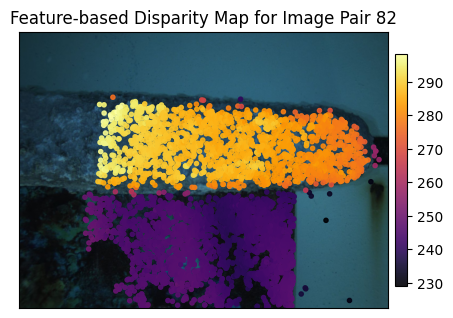

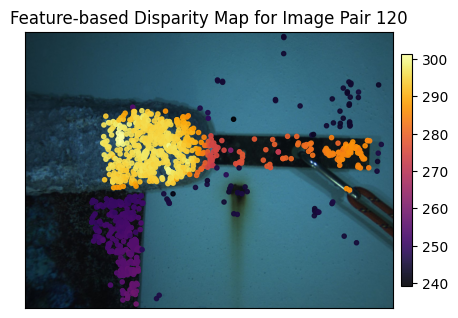

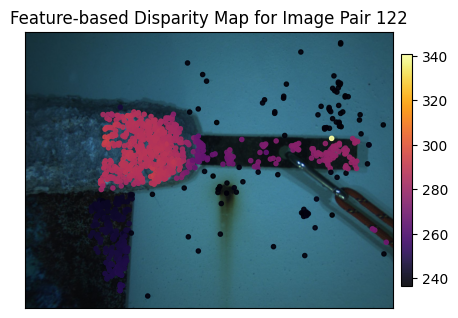

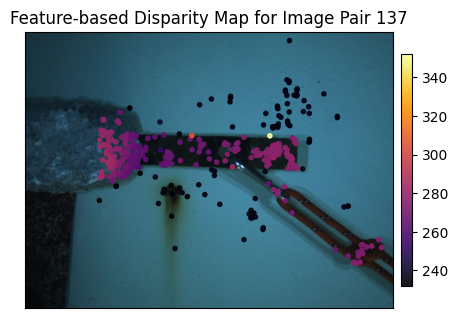

In [223]:
# (Code) Displaying the disparity map
for ii in range(len(indices)):
    i = indices[ii]
    disp = disparities_list[ii]
    kptsL = kptsL_list[ii]
    matches = matches_list[ii]
    radius = 3
    title = f"Feature-based Disparity Map for Image Pair {i}"
    plot_feature_based_disparity(left_rectified[i], kptsL, matches, disp, radius, title, "left")

vmin = 0.36215187158255735, vmax = 0.45136232205072685


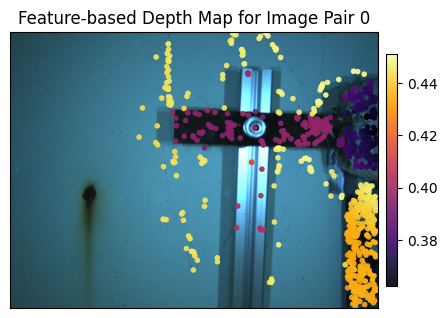

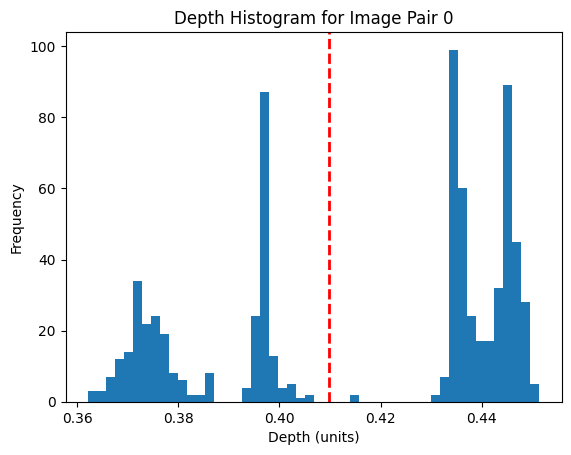

vmin = 0.3633528497115897, vmax = 0.458243831707659


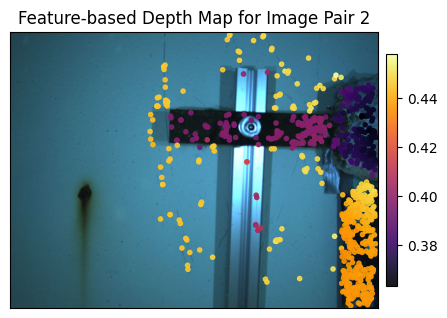

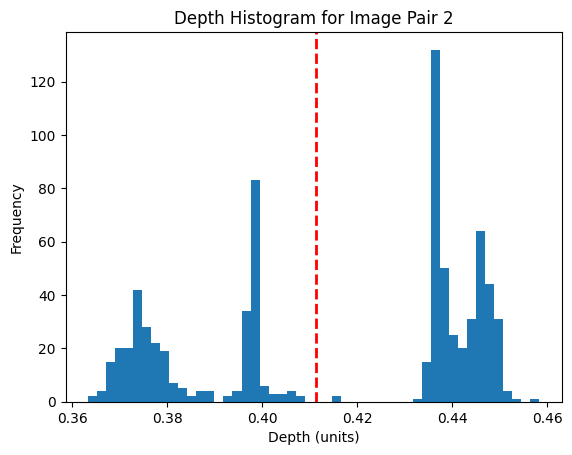

vmin = 0.38193364078493414, vmax = 0.5105760419836515


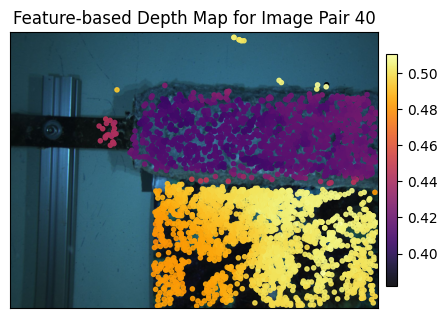

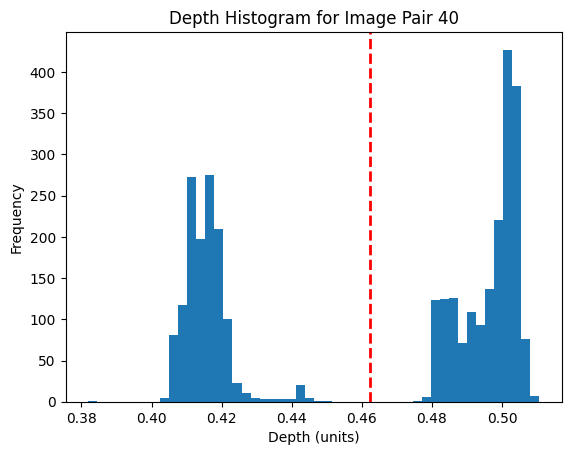

vmin = 0.4021714159688105, vmax = 0.5194003761890211


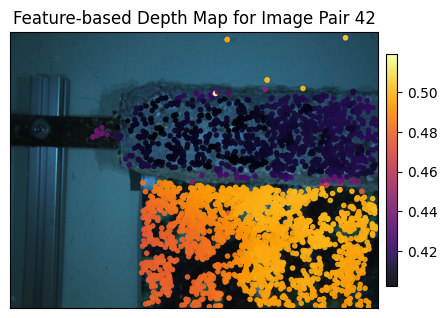

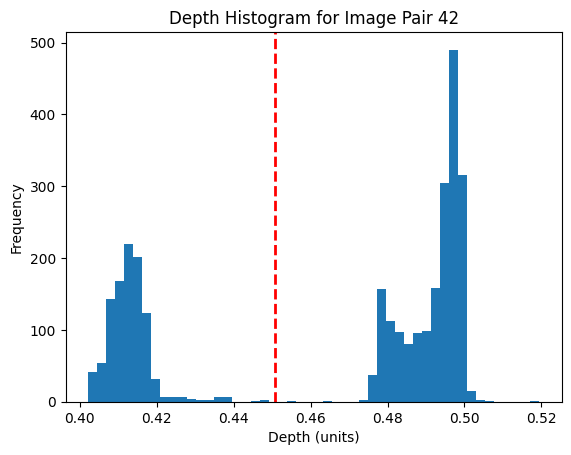

vmin = 0.44214025538338186, vmax = 0.5931461110228666


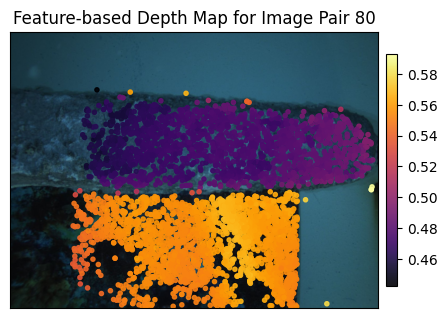

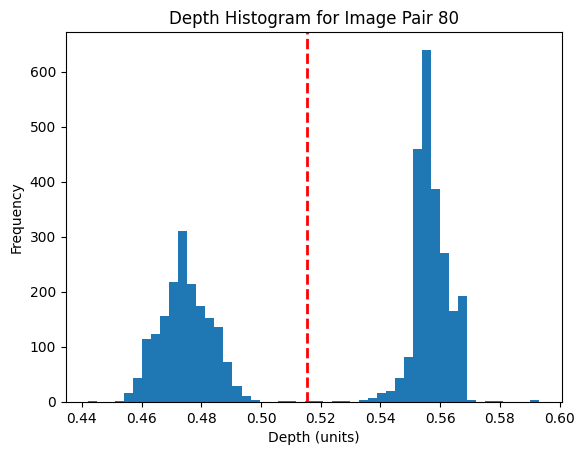

vmin = 0.4182856203022463, vmax = 0.544734893768784


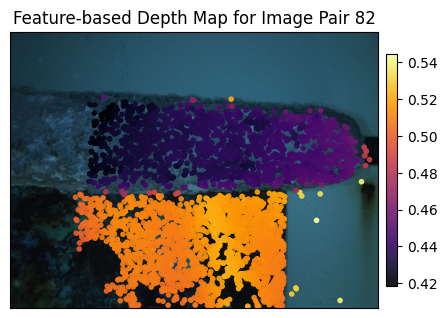

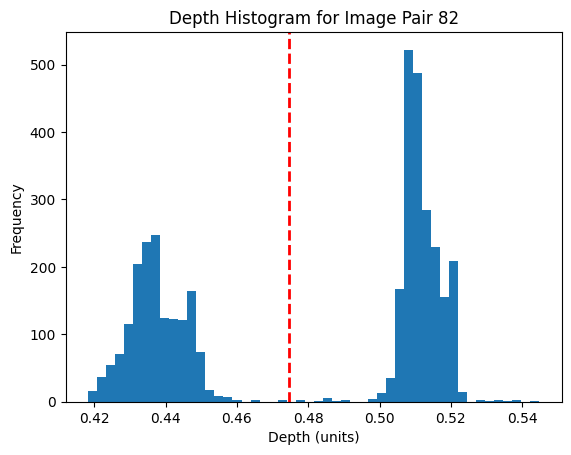

vmin = 0.413927837601335, vmax = 0.5217545456071627


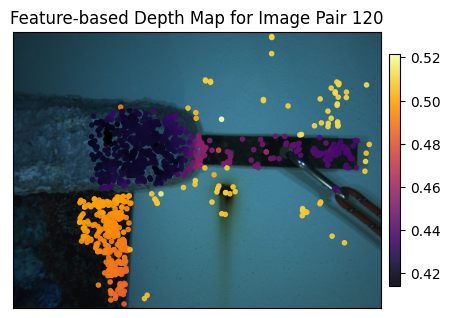

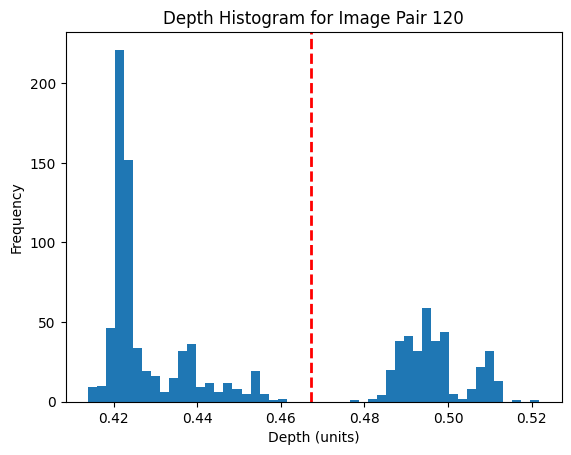

vmin = 0.36595827380332685, vmax = 0.5278436167324152


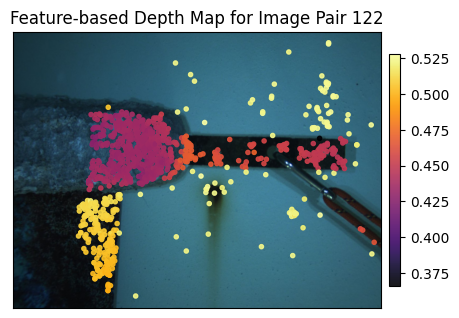

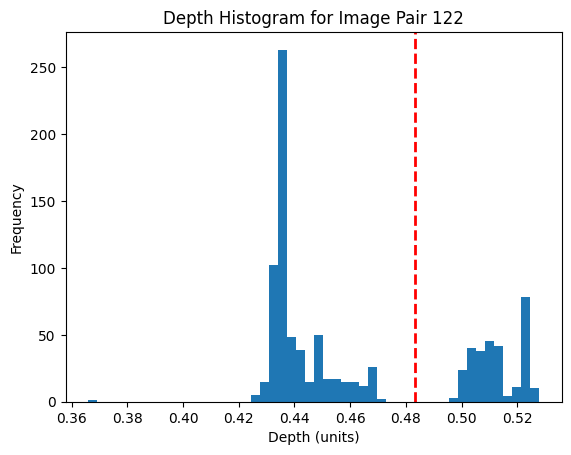

vmin = 0.3542566511786147, vmax = 0.5383103126809978


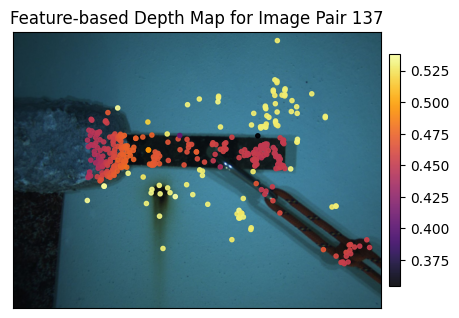

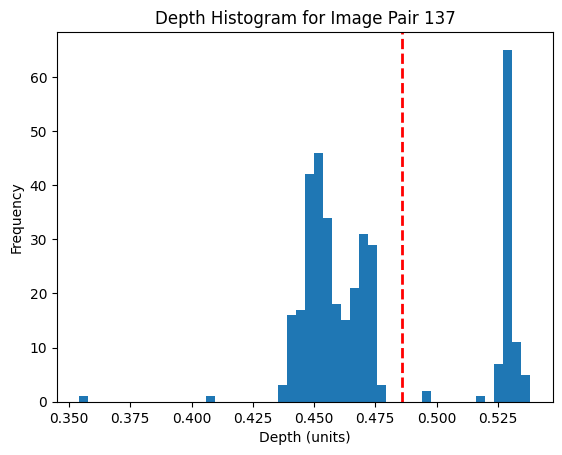

In [224]:
# (Code) Displaying the depth map
for ii in range(len(indices)):
    i = indices[ii]
    depth = depth_list[ii]
    kptsL = kptsL_list[ii]
    matches = matches_list[ii]
    radius = 3
    title = f"Feature-based Depth Map for Image Pair {i}"
    plot_feature_based_disparity(left_rectified[i], kptsL, matches, depth, radius, title, "left")
    plt.show()
    hist, bin_edges, patches = plt.hist(depth, bins=50)
    # find threshold
    threshold = find_optimal_threshold(depth)
    # draw vertical red line at threshold
    plt.axvline(threshold, color='r', linestyle='--', linewidth=2)
    plt.title(f"Depth Histogram for Image Pair {i}")
    plt.xlabel("Depth (units)")
    plt.ylabel("Frequency")
    plt.show()

Discussion on the trade-offs between feature-based or dense stereo matching approaches. Justify your selection.

 * Point density: Dense stereo matching creates much denser depth maps than feature based approaches (+dense)

 * Depth Map reliability: Feature based approaches are much more reliable than dense stereo matching methods. This is due to the use of descriptors, that encode much more information about any pixel in the image than a small window around the pixel as used in dense stereo matching. (+feature)

 * Noise: Feature based approaches result in less noisy depth maps (+feature)

 * Initial pose for registration: Feature based approaches enable a better initial pose for registration by computing the matches between the left images of successive timestamps. (+feature)
 
 We chose the feature based approach to avoid the unreliability of dense stereo matching. Besides, the object of interest has a lot of texture, and many keypoints and found in the object of interest.

# Exercise 3 - Point Cloud Generation and Preprocessing
Transform depth maps into 3D point clouds. Using the standard projection formula, each pixel in the depth map can be reprojected into 3D space, yielding a set of points that represent the visible surface of the anode. To make the model visually meaningful, assign color information from the corresponding pixels in the left image to each 3D point. This process produces a textured point cloud, allowing you to visually identify surface details and material characteristics directly in 3D.

Before further processing, it's essential to clean and refine the point clouds. Raw reconstructions often contain noise, especially in regions affected by low contrast, refraction, or poor stereo matching. Begin by removing outliers to eliminate isolated or spurious points that don't belong to the actual surface. If the resulting dataset is too large or unevenly sampled, you may downsample the point cloud to a uniform density, improving computational efficiency for subsequent registration steps. Optionally, you can also apply smoothing filters to reduce small-scale noise and improve surface continuity.


In [ ]:
def sigmoid(x, )

In [ ]:
# do implementation here

def depth2pointcloud(img, kpts, matches, depth, side: str, calib_dict: Dict[str, Any]) -> o3d.geometry.PointCloud:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    points_3D = []
    colors = []
    P2 = calib_dict["P2"]
    fx = P2[0, 0]
    fy = P2[1, 1]
    cx = P2[0, 2]
    cy = P2[1, 2]

    for i in range(len(matches)):
        match = matches[i][0]
        if side == 'left':
            idx = match.queryIdx
        else:
            idx = match.trainIdx
        
        u, v = kpts[idx].pt
        Z = depth[i]
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        points_3D.append([X, Y, Z])
        c = img_rgb[int(v), int(u), :] / 255.0  # Normalize color to [0, 1]
        colors.append(c)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(points_3D))
    pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

    return pcd

def extract_pcd(imgL_list, imgR_list, index, calib_dict):
    # 1) extract keypoints and descriptors using SIFT
    sift_params = {"nfeatures": 10000,
                   "contrastThreshold": 0.01,
                   "edgeThreshold": 20}

    kptsL, dscL = extract_keypoints_and_descriptors_SIFT(imgL_list[index], sift_params)
    kptsR, dscR = extract_keypoints_and_descriptors_SIFT(imgR_list[index], sift_params)


    # 2) match keypoints
    ratio = 0.75  
    matches = match_descriptors(dscL, dscR, ratio)

    # 3) compute disparities, filter out non aligned matches
    disparities, matches_filt = matches2disparity(kptsL, kptsR, matches)
    
    # 5) compute depths from disparities
    depths = disparity2depth(disparities, calib_dict)

    # 6) generate point cloud
    pcd = depth2pointcloud(imgL_list[index], kptsL, matches_filt, depths, 'left', calib_dict)

    return pcd

def filter_pcd_radius(pcd: o3d.geometry.PointCloud, matches, radius: float, min_neighbors_near: int, min_neighbors_far: int, minDepth: float, maxDepth: float) -> o3d.geometry.PointCloud:
    
    # extract points
    points = np.asarray(pcd.points)

    

    filtered_pcd, ind = pcd.remove_radius_outlier(nb_points=min_neighbors, radius=radius)
    # extract matches that passed the filter
    matches_filt = [matches[i] for i in ind]
    return filtered_pcd, matches_filt

def exercise3(imgL_list, imgR_list, indices, calib_dict, verbose: bool):
    pcd_list = []
    for ii in range(len(indices)):
        index = indices[ii]
        if verbose:
            print(f"Extracting point cloud for image pair: {index} ({ii+1}/{len(indices)})")
        pcd = extract_pcd(imgL_list, imgR_list, index, calib_dict)
        pcd_list.append(pcd)
        if verbose:
            print(f"  point cloud has {len(pcd.points)} points.")
    return pcd_list
    
    
       

In [148]:
indices = [0, 2, 40, 42]
pcd_list = exercise3(left_rectified, right_rectified, indices, stereo_calib_dict, verbose=True)

Extracting point cloud for image pair: 0 (1/4)
  point cloud has 731 points.
Extracting point cloud for image pair: 2 (2/4)
  point cloud has 756 points.
Extracting point cloud for image pair: 40 (3/4)
  point cloud has 3240 points.
Extracting point cloud for image pair: 42 (4/4)
  point cloud has 3001 points.


**Deliverable:**


In [149]:
#  Visualization of one pre-filtered point cloud with texture (Open3D)
ii = 0
ii = ii%len(pcd_list)
pcd = pcd_list[ii]
print(f"Displaying point cloud for image pair: {indices[ii]}")
draw_geometries([pcd])


Displaying point cloud for image pair: 0


In [151]:
#  Visualization of one post-filtered point clouds with texture (Open3D)
ii = 0
ii = ii%len(pcd_list)
pcd = pcd_list[ii]
print(f"Displaying filtered point cloud for image pair: {indices[ii]}")
pcd_filt, matches_filt = filter_pcd_radius(pcd, matches_list[ii], radius=0.01, min_neighbors=5, minDepth=0.35, maxDepth=0.55)
draw_geometries([pcd_filt])

Displaying filtered point cloud for image pair: 0


 - Discussion about the technical decisions as well as, the outcome related to noise, density and visual appearance.

 <font color='red'> Justify Here (3 lines) ... </font>

# Exercise 4 — 3D Registration of Two Consecutive Point Clouds

Begin the reconstruction process by focusing on the alignment of **two consecutive point clouds**. Each cloud represents a partial view of the anode captured from slightly different camera positions as the stereo rig moves laterally. To create a 3D model, these views must be accurately registered in a common coordinate system. Start with an initial alignment. This rough alignment serves as the starting point for a more precise adjustment. Next, refine the registration using an Iterative Closest Point (ICP) -based algorithm. ICP iteratively minimizes the distance between overlapping regions of the two point clouds, improving their relative alignment until convergence. The result should be a well-registered pair of clouds that fit together smoothly, forming a coherent section of the anode's surface.

In [ ]:
# do implementation here

**Deliverable:**

In [ ]:
# Visualization of the aligned model (Open3D)

In [ ]:
# Report ICP convergence metrics (residuals, iterations).

 - Describe the reasons for selecting a specific 3D Registration technique for this problem (error, density and visual appearance).

 <font color='red'> Justify Here (4 lines) ... </font>

# Exercise 5 — Multi-view 3D Registration

Extend your registration process to the entire dataset. Instead of aligning only two consecutive point clouds, sequentially register all valid point clouds acquired along the scanning path. Each new alignment should build upon the previous ones, gradually assembling a complete representation of the anode.
Once all point clouds have been successfully registered into a single coordinate frame, merge them to create the full 3D model. Incorporate the color information from the left images to produce a textured reconstruction, capturing both the geometry and visual appearance of the anode.

The outcome of this step should be a cohesive, high-quality 3D model that accurately reflects the anode's surface structure and material characteristics across its entire length.

In [ ]:
# do implementation here

**Deliverable:**

In [ ]:
# Visualization of the model of the anode (Open3D)

In [ ]:
# Save of the anode model to a file (Open3D).
# ATTENTION::: Download the file to your computer since it will be needed during the submission of the assignment.

# Exercise 6 — Physical Measurements of the Anode

With the complete 3D reconstruction of the anode now available, the next step is to extract key physical measurements from the model. These quantitative assessments will help evaluate both the geometry of the anode and the accuracy of your reconstruction.

Compute the following parameters:

- Maximum width along the X-axis — representing the total horizontal span of the anode.

- Maximum height along the Y-axis — corresponding to its vertical extent.

- Total volume.

- Width of the supporting metal brackets located at each end of the anode.

Finally, visualize these measurements directly on the 3D model using annotated plots or overlays.

In [ ]:
# do implementation here

**Deliverable:**

A short table with all measured quantities.

<font color='red'> Add table here ... </font>

Justify of how measurements were obtained (the implementation that was performed to automatically extract the values).

 <font color='red'> Justify Here (4 lines) ... </font>

--------------------------------------------------------------------------

# Ethics

<font color='red'>
Disclaimer for the use of AI tools: complete the text that is placed in between brackets. Convert this disclaimer to PDF, sign it and deliver the PDF in Moodle.
</font>


<font color='red'> [Student Name #1] </font> and <font color='red'> [Student Name #2] </font> declare that the work presented in this assignment titled "[Assignment Title]" was completed independently, except where explicitly noted. I confirm the following with regard to the use of AI tools:

**Extent of AI Tool Contribution:**

I have used the following AI tool(s) for assistance in this assignment:

1. Tool(s) Used: [List AI tools used, e.g., ChatGPT, Grammarly, QuillBot, etc.]
Nature of Assistance: [Specify the task(s) for which the AI tool was used, e.g., brainstorming ideas, refining language, generating summaries, grammar correction, etc.]
2. Percentage of AI Contribution: [Estimate the percentage of the assignment influenced by the AI tool.]
3. Human Oversight and Contribution:
Despite the use of AI tools, I confirm that the critical thinking, analysis, problem-solving, and final decision-making processes in this assignment were carried out by me. The AI tools were used solely as support for the following purposes: [Elaborate on how the AI tool helped, e.g., improving readability, offering suggestions for structure, or enhancing clarity.]


**Originality and Integrity:**
I take full responsibility for ensuring that the content of this assignment is original and properly cited where applicable. The use of AI tools did not result in any unintentional plagiarism or misrepresentation of ideas from external sources.

**Compliance with Academic Integrity Guidelines:**
I understand the importance of academic integrity, and I confirm that the usage of AI tools complies with the guidelines provided by [School/University Name]. All AI-generated outputs were critically evaluated and appropriately incorporated into the final submission.

Signed,
[Student Name]
[Date]